#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV , train_test_split, TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
min(data['datetime'])

'2018-03-01 00:00:00'

In [7]:
max(data['datetime'])

'2018-08-31 23:50:00'

**Вывод:** пропусков нет, дубликатов нет. Данные собраны за пол года.

**Установим индексы по столбцу datetime, отсортируем и проверим хронологию расположения**

In [8]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
data = data.sort_index()
data.index.is_monotonic

True

In [10]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Анализ

**Посмотрим на количество заказов по дням**

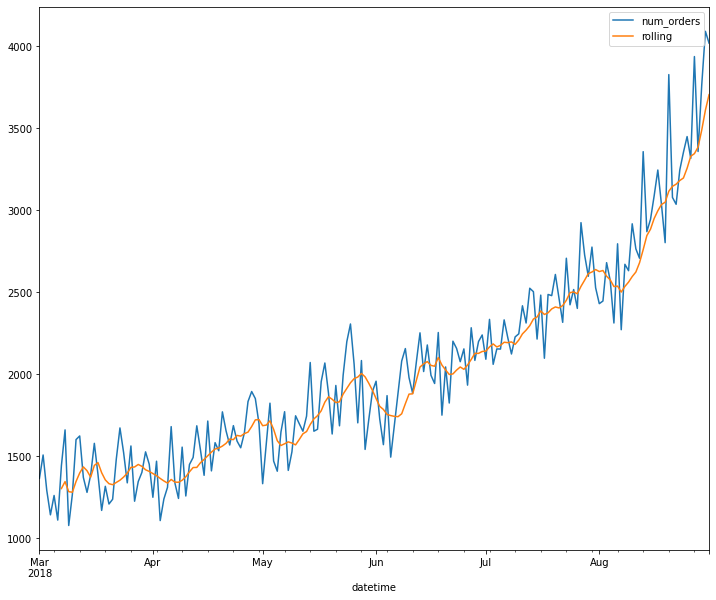

In [11]:
day = data.resample('1D').sum()
day['rolling'] = day.rolling(7).mean()
day.plot(figsize=(12,10));

**Вывод:** из графика видно, что количесвто заказов к концу августа растет. Августовский рост заказов такси может быть трендом, зачастую люди улетают в отпуск или возвращаются из него в августе. 

Эту гипотезу проверить невозможно, так как данных за предыдущие года у нас нет.

**Апрель более "ровный" по сравнению с другими месяцами. Проведем анализ одной недели в апреле, ресемплированных по часу**

In [12]:
data = data.resample('1H').sum()

In [13]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-04-7'])

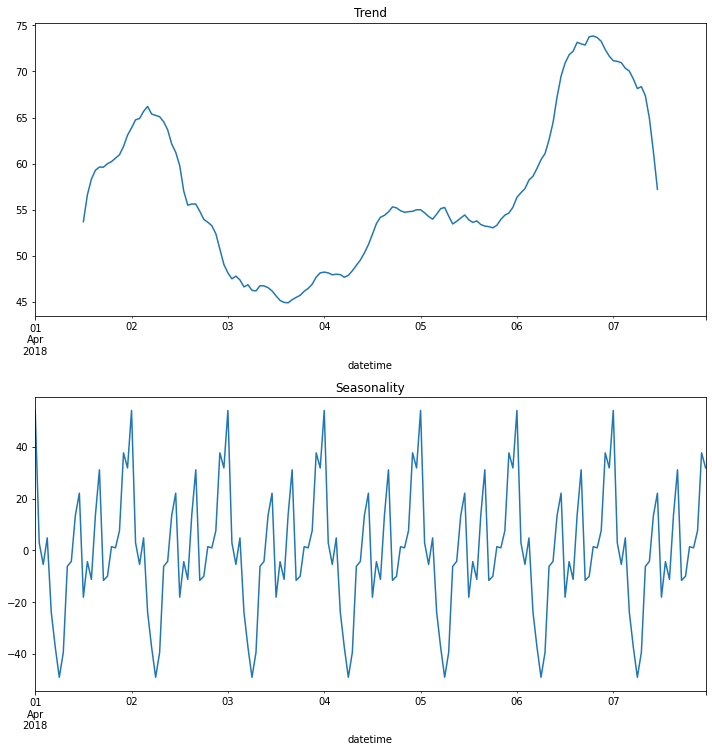

In [14]:
plt.figure(figsize=(10,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

**Вывод:** из графика тренда видно, количество заказов такси в выходные дни и утро понедельника растет. А сезонность показывает рост количества заказов к вечеру.

In [15]:
decomposed_2 = seasonal_decompose(data['2018-04-01':'2018-04-2'])

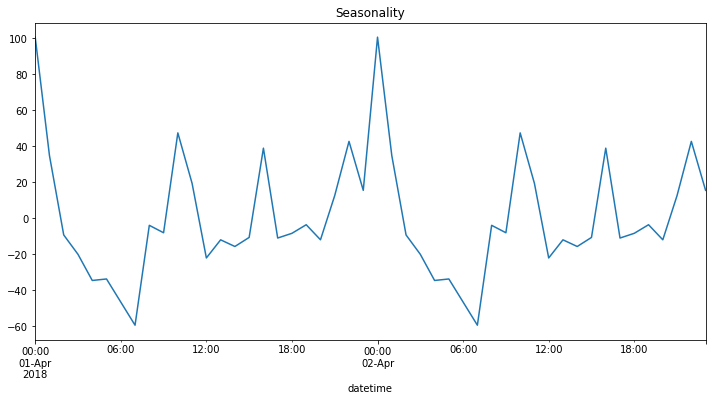

In [16]:
plt.figure(figsize=(10,15))
plt.subplot(313)
decomposed_2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

**Вывод:** с 12 часов ночи до 6 утра количество заказов падает, в то время как в вечернее время их количество растет

## Обучение

### Создание признаков

In [17]:
def make_features(df,max_lag,rolling_mean_size):
    new_data = df.copy()
    new_data['month'] = new_data.index.month
    new_data['day_of_week'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag+1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
        
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

rolling_mean_size примем за 168. Именно столько часов в одной неделе

In [18]:
new_data = make_features(data,24,168)
new_data = new_data.dropna()
new_data.head()

,num_orders,month,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,3,0,94.0,127.0,108.0,76.0,50.0,99.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,3,1,143.0,94.0,127.0,108.0,76.0,50.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,3,2,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,3,3,65.0,78.0,143.0,94.0,127.0,108.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,3,4,68.0,65.0,78.0,143.0,94.0,127.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810


In [19]:
new_data.shape

(4248, 29)

### Разбика данных на тренировочную и тестовую

In [20]:
RANDOM = 12345

In [21]:
data_train, data_sep = train_test_split(new_data,train_size=0.8, test_size=0.2, random_state=RANDOM, shuffle=False)

In [22]:
data_valid, data_test = train_test_split(data_sep, test_size=0.5, random_state=RANDOM, shuffle=False)

In [23]:
features_train = data_train.drop(['num_orders'],axis=1)
target_train = data_train['num_orders']

In [24]:
features_valid = data_valid.drop(['num_orders'],axis=1)
target_valid = data_valid['num_orders']

In [25]:
features_test = data_test.drop(['num_orders'],axis=1)
target_test = data_test['num_orders']

In [26]:
def rmse(target,pred):
    rmse = mean_squared_error(target,pred)**0.5
    return round(rmse,2)

### Линейная регрессия

In [27]:
times_cv = TimeSeriesSplit(n_splits=3)

In [28]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
model_lr_cv_score = cross_val_score(model_lr, 
                                 features_train, 
                                 target_train,
                                 scoring='neg_root_mean_squared_error', 
                                    cv=times_cv)
print('RMSE модели c КВ: ', round(model_lr_cv_score.mean()*-1,2))

RMSE модели c КВ:  26.95


### CatBoost

In [29]:
# times_cv = TimeSeriesSplit(n_splits=3)

In [30]:
# cat = CatBoostRegressor(loss_function='RMSE',random_seed=RANDOM,silent=True)

In [31]:
# params = {
#     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'iterations': range(10, 100, 10),
#     'depth': range(4,10,2)
# }

In [32]:
# grid_cat = GridSearchCV(cat,params,cv=times_cv,scoring='neg_root_mean_squared_error')
# grid_cat.fit(features_train, target_train);
# grid_cat.best_params_

In [33]:
cat = CatBoostRegressor(depth=6, iterations=90, learning_rate=0.1,loss_function='RMSE',random_seed=RANDOM,silent=True)
cat.fit(features_train,target_train)
prediction = cat.predict(features_valid)
rmse_cat = rmse(target_valid,prediction)
print('RMSE модели: ', rmse_cat)

RMSE модели:  32.4


### RandomForest

In [34]:
# times_cv = TimeSeriesSplit(n_splits=3)

In [35]:
# model_rfr = RandomForestRegressor(random_state=RANDOM)

In [36]:
# params = {
#     'max_depth':range(1,23,3),
#     'n_estimators': range(1,100,10),
#     'min_samples_leaf': range(1,5)
# }

In [37]:
# grid_rfr = GridSearchCV(model_rfr,params,cv=times_cv,scoring='neg_root_mean_squared_error')
# grid_rfr.fit(features_train, target_train)
# grid_rfr.best_params_

In [38]:
model_rfr = RandomForestRegressor(max_depth=22, n_estimators=91,min_samples_leaf=1, random_state=RANDOM)
model_rfr.fit(features_train,target_train)
prediction = model_rfr.predict(features_valid)
rmse_rfr = rmse(target_valid,prediction)
print('RMSE модели: ', rmse_rfr)

RMSE модели:  32.41


**Вывод:** лучший показатель метрики RMSE у Линейной регрессии - 26.95

## Тестирование

In [39]:
lr_pred = model_lr.predict(features_test)
print('RMSE модели на тестовой выборке: ', rmse(target_test,lr_pred))

RMSE модели на тестовой выборке:  44.93


**Рассмотрим полученные результаты**

In [42]:
comparison = pd.DataFrame({"target":target_test, "predict":lr_pred})
comparison

,target,predict
datetime,,
2018-08-14 07:00:00,54,48.896918
2018-08-14 08:00:00,91,96.831450
2018-08-14 09:00:00,135,124.803664
2018-08-14 10:00:00,155,128.419241
2018-08-14 11:00:00,162,140.155555
...,...,...
2018-08-31 19:00:00,136,108.616830
2018-08-31 20:00:00,154,150.740923
2018-08-31 21:00:00,159,179.275096


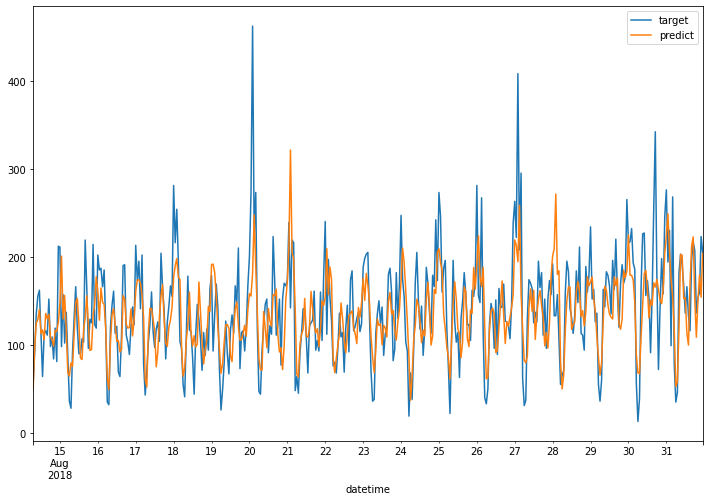

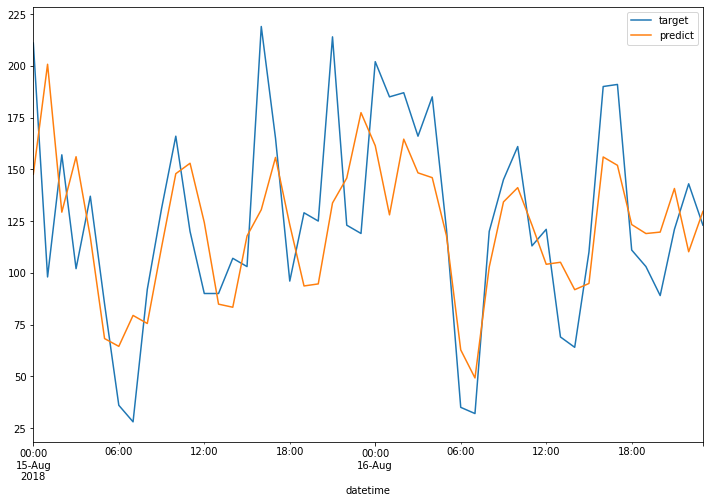

In [43]:
comparison.plot(figsize=(12,8));
comparison['2018-08-15':'2018-08-16'].plot(figsize=(12,8));

## Вывод

В ходе анализа выявлено, что чаще всего такси пользуются в выходные дни и в понедельник утром. Возможно большое количество заказов в августе связано с отпусками, а именно с прибытием и убитием (достоверно это не проверить).

После рассмотрения моделей, подбора к ним параментов и тестирования, лучшие всего себя показала LinearRegression